In [32]:
import os
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

plt.style.use("ggplot")

PROJECT_ROOT = os.path.abspath("..")
DATASET_PATH = os.path.join(PROJECT_ROOT, "data", "raw", "emotion-fer")

In [33]:
splits = [
    d for d in os.listdir(DATASET_PATH)
    if os.path.isdir(os.path.join(DATASET_PATH, d))
]

print("Detected splits:", splits)

Detected splits: ['test', 'train']


In [34]:
data_records = []
for split in splits:
    split_path = os.path.join(DATASET_PATH, split)
    for label in os.listdir(split_path):
        label_path = os.path.join(split_path, label)
        if not os.path.isdir(label_path):
            continue
        for file_name in os.listdir(label_path):
            file_path = os.path.join(label_path, file_name)
            data_records.append({
                "split": split,
                "label": label,
                "filepath": file_path
            })
df = pd.DataFrame(data_records)
print(f"Total Images: {len(df)}")

Total Images: 35887


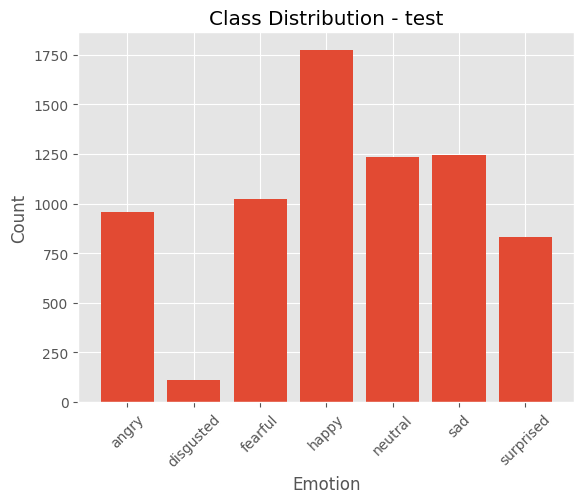

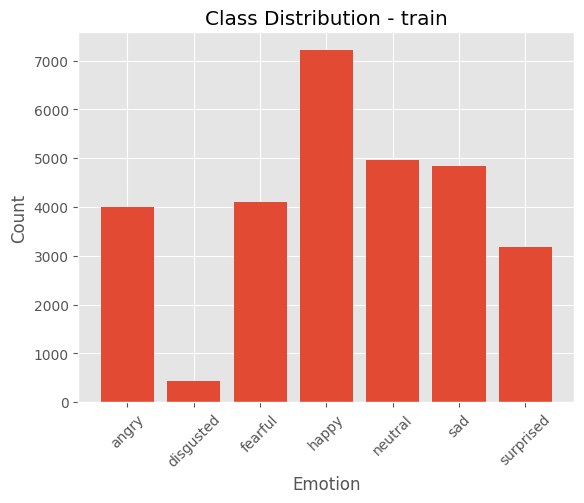

In [35]:
class_distribution = df.groupby(["split", "label"]).size().reset_index(name="count")
for split in splits:
    subset = class_distribution[class_distribution["split"] == split]
    plt.figure()
    plt.bar(subset["label"], subset["count"])
    plt.title(f"Class Distribution - {split}")
    plt.xticks(rotation=45)
    plt.xlabel("Emotion")
    plt.ylabel("Count")
    plt.show()

In [36]:
imbalance_stats = df.groupby("label").size()
print("Class Counts:\n", imbalance_stats)
print("\nImbalance Ratio (max/min):", imbalance_stats.max() / imbalance_stats.min())

Class Counts:
 label
angry        4953
disgusted     547
fearful      5121
happy        8989
neutral      6198
sad          6077
surprised    4002
dtype: int64

Imbalance Ratio (max/min): 16.43327239488117


In [37]:
resolutions = []
aspect_ratios = []

for path in tqdm(df["filepath"][:2000], desc="Reading images for resolution/aspect"):
    try:
        img = Image.open(path).convert("L")
        width, height = img.size
        resolutions.append((width, height))
        aspect_ratios.append(width / height)
    except:
        continue

resolution_df = pd.DataFrame(resolutions, columns=["width", "height"])
resolution_df["aspect_ratio"] = aspect_ratios
print(resolution_df.describe())

Reading images for resolution/aspect: 100%|██████████| 2000/2000 [00:00<00:00, 3664.18it/s]

        width  height  aspect_ratio
count  2000.0  2000.0        2000.0
mean     48.0    48.0           1.0
std       0.0     0.0           0.0
min      48.0    48.0           1.0
25%      48.0    48.0           1.0
50%      48.0    48.0           1.0
75%      48.0    48.0           1.0
max      48.0    48.0           1.0


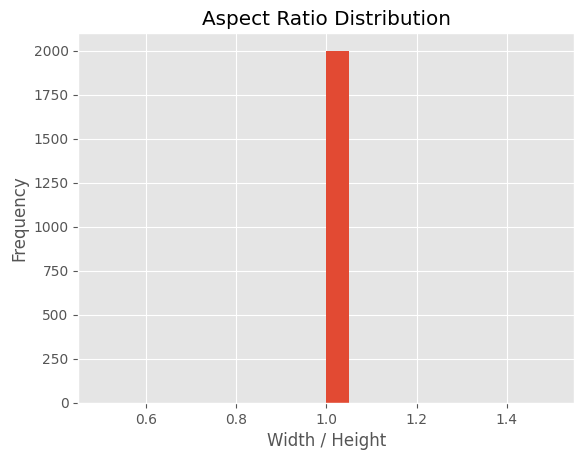

In [38]:
plt.figure()
plt.hist(resolution_df["aspect_ratio"], bins=20)
plt.title("Aspect Ratio Distribution")
plt.xlabel("Width / Height")
plt.ylabel("Frequency")
plt.show()

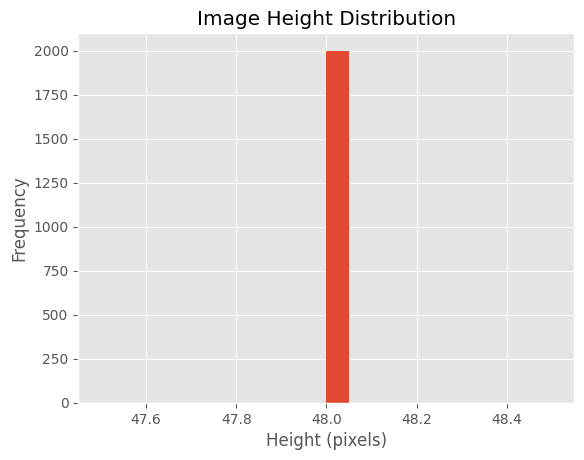

In [39]:
plt.figure()
plt.hist(resolution_df["height"], bins=20)
plt.title("Image Height Distribution")
plt.xlabel("Height (pixels)")
plt.ylabel("Frequency")
plt.show()

Sampling pixel intensities:   0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\jobet\AppData\Local\Temp\ipykernel_18128\2046394381.py:6: DeprecationWarning: Image.Image.getdata is deprecated and will be removed in Pillow 14 (2027-10-15). Use get_flattened_data instead.
  pixel_values.extend(list(img.getdata()))
Sampling pixel intensities: 100%|██████████| 1000/1000 [00:00<00:00, 2703.96it/s]


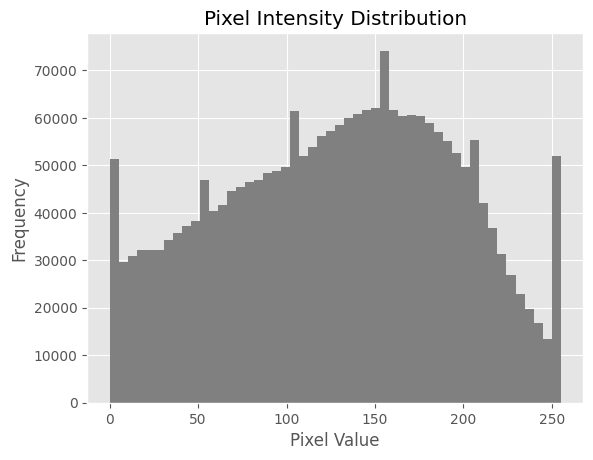

In [40]:
pixel_values = []

for path in tqdm(df["filepath"][:1000], desc="Sampling pixel intensities"):
    try:
        img = Image.open(path).convert("L")
        pixel_values.extend(list(img.getdata()))
    except:
        continue

plt.figure()
plt.hist(pixel_values, bins=50, color="gray")
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

In [41]:
pixel_stats = []

for label in df["label"].unique():
    paths = df[df["label"] == label]["filepath"].tolist()
    pixels = []

    for path in paths[:500]:
        try:
            img = Image.open(path).convert("L")
            pixels.extend(img.get_flat_data())
        except Exception:
            continue

    if pixels:
        mean_pixel = sum(pixels) / len(pixels)
        std_pixel = pd.Series(pixels).std()
    else:
        mean_pixel = 0
        std_pixel = 0

    pixel_stats.append({
        "label": label,
        "mean_pixel": mean_pixel,
        "std_pixel": std_pixel
    })

pixel_stats_df = pd.DataFrame(pixel_stats)
print("Pixel Statistics Per Class:")
print(pixel_stats_df)


Pixel Statistics Per Class:
       label  mean_pixel  std_pixel
0      angry           0          0
1  disgusted           0          0
2    fearful           0          0
3      happy           0          0
4    neutral           0          0
5        sad           0          0
6  surprised           0          0


In [42]:
def file_hash(path):
    try:
        with open(path, "rb") as f:
            return hashlib.md5(f.read()).hexdigest()
    except:
        return None

hashes = {}
duplicates = []

for path in tqdm(df["filepath"], desc="Checking duplicates"):
    h = file_hash(path)
    if h:
        if h in hashes:
            duplicates.append((path, hashes[h]))
        else:
            hashes[h] = path

print(f"Duplicate Images Found: {len(duplicates)}")
if duplicates:
    print("Example duplicates:", duplicates[:3])


Checking duplicates: 100%|██████████| 35887/35887 [00:02<00:00, 14176.78it/s]

Duplicate Images Found: 0


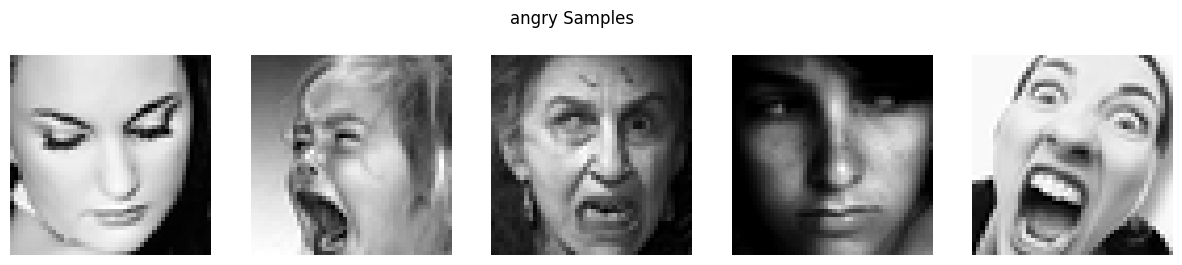

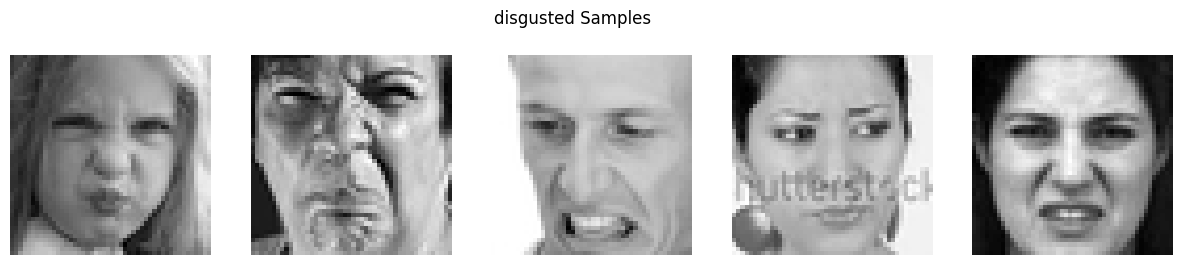

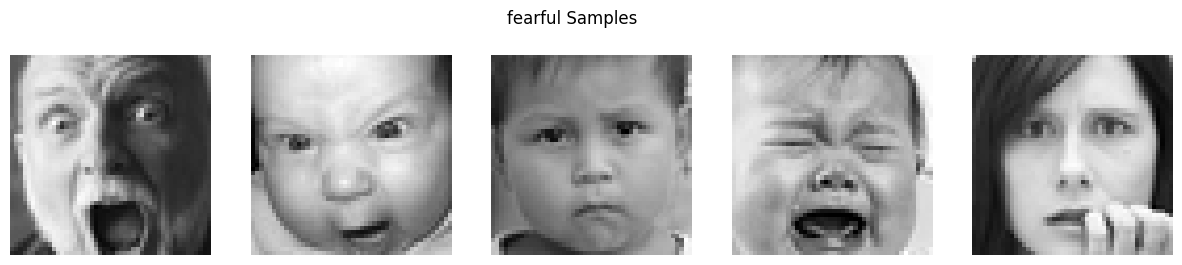

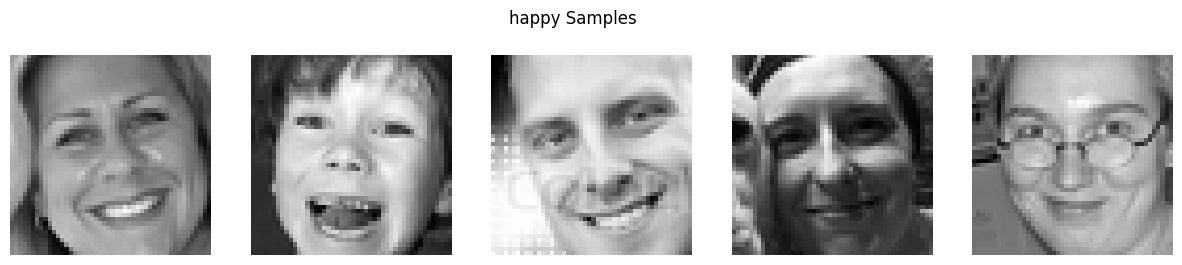

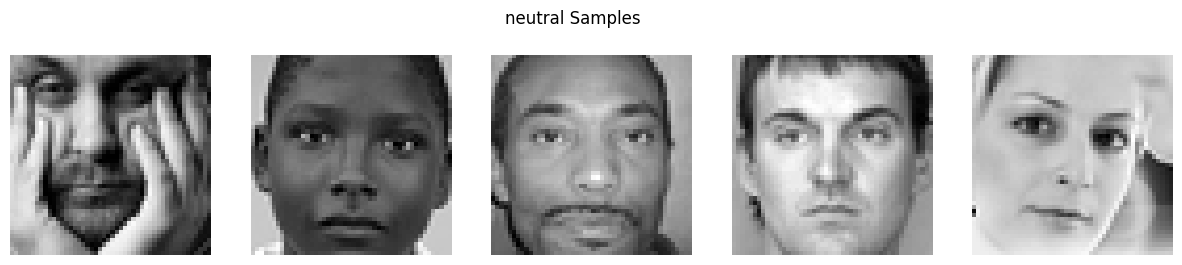

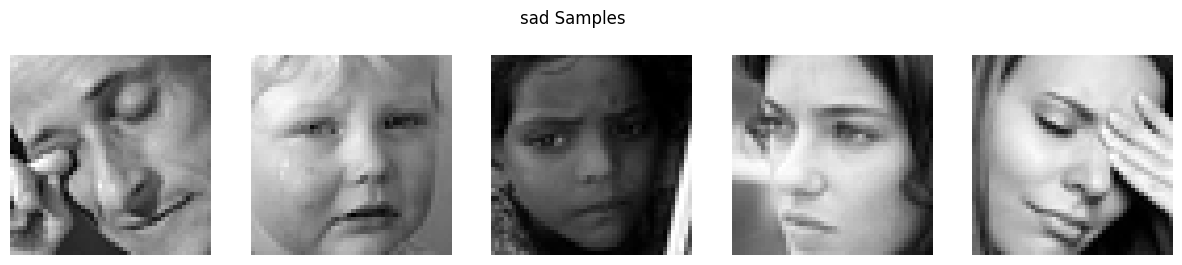

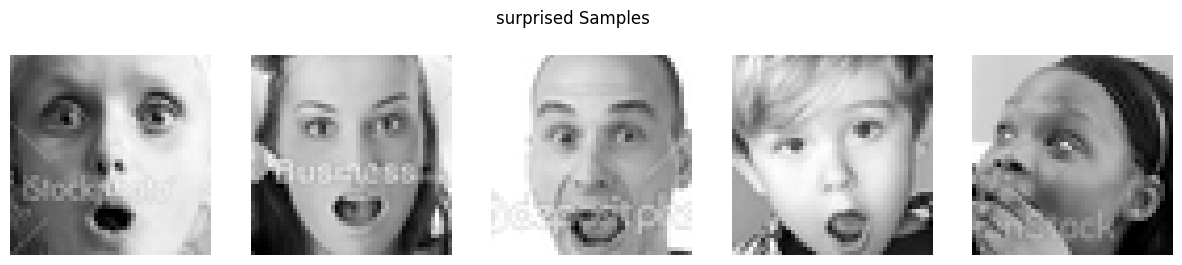

In [43]:
def plot_sample_grid(split="train", samples_per_class=5):
    subset = df[df["split"] == split]
    labels = subset["label"].unique()

    for label in labels:
        label_subset = subset[subset["label"] == label].sample(samples_per_class)
        fig, axes = plt.subplots(1, samples_per_class, figsize=(15, 3))
        for ax, row in zip(axes, label_subset.itertuples()):
            try:
                img = Image.open(row.filepath).convert("L")
                ax.imshow(img, cmap="gray")
                ax.axis("off")
            except:
                ax.axis("off")
        plt.suptitle(f"{label} Samples")
        plt.show()

plot_sample_grid()

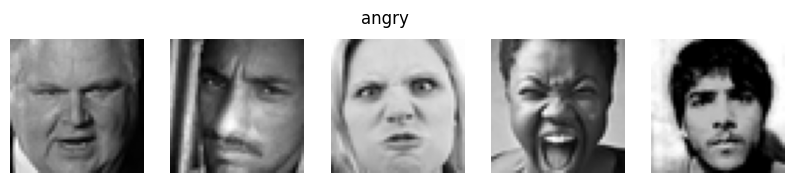

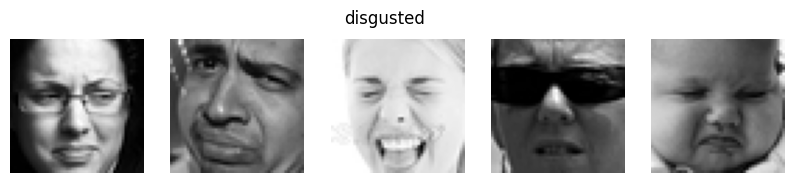

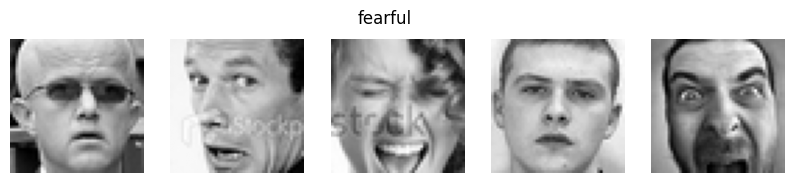

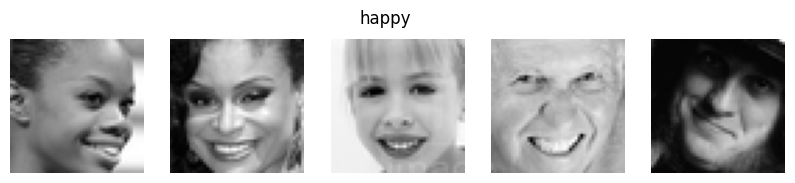

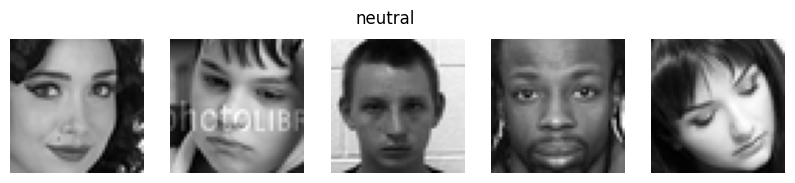

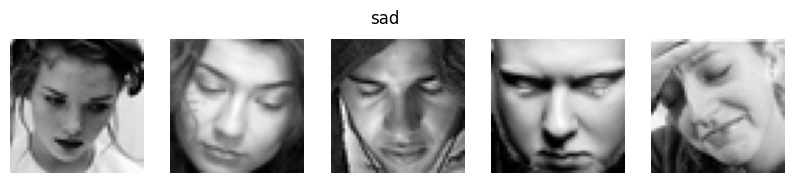

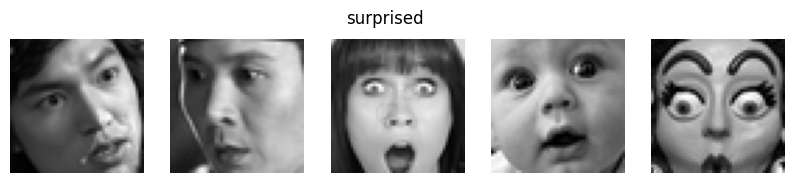

In [44]:
def show_samples_per_class(split="train", samples=5):
    subset = df[df["split"] == split]
    labels = subset["label"].unique()

    for label in labels:
        label_subset = subset[subset["label"] == label].sample(samples)
        plt.figure(figsize=(10, 2))
        for i, row in enumerate(label_subset.itertuples()):
            try:
                img = Image.open(row.filepath).convert("L")
                plt.subplot(1, samples, i + 1)
                plt.imshow(img, cmap="gray")
                plt.axis("off")
            except:
                continue
        plt.suptitle(label)
        plt.show()

show_samples_per_class()

In [45]:
corrupted = []
for path in tqdm(df["filepath"], desc="Checking corrupted images"):
    try:
        img = Image.open(path)
        img.verify()
    except:
        corrupted.append(path)
print(f"Corrupted Images: {len(corrupted)}")

Checking corrupted images: 100%|██████████| 35887/35887 [00:05<00:00, 6921.55it/s]

Corrupted Images: 0


In [46]:
summary = {
    "total_images": len(df),
    "splits": splits,
    "num_classes": df["label"].nunique(),
    "imbalance_ratio": imbalance_stats.max() / imbalance_stats.min(),
    "corrupted_images": len(corrupted),
    "duplicate_images": len(duplicates)
}

print("========== ADVANCED EDA SUMMARY ==========")
for key, value in summary.items():
    print(f"{key}: {value}")
print("==========================================")

========== ADVANCED EDA SUMMARY ==========
total_images: 35887
splits: ['test', 'train']
num_classes: 7
imbalance_ratio: 16.43327239488117
corrupted_images: 0
duplicate_images: 0
